In [1]:
import pandas as pd
import numpy as np

from tqdm.notebook import tqdm
import datetime

from timeit import timeit
from AvailableErrors import *
from Andrii.Dir_Task_JAN_FEB.tools_functions import createTimeDifference

In [2]:
global _WEEK_DICT, _HOLIDAY
_WEEK_DICT = {0:'ПН', 1:'ВТ', 2:'СР', 3:'ЧТ', 4:'ПТ', 5:'СБ', 6:'ВС'}
_HOLIDAY_MARKERS = [5,6]

In [28]:
class StrategyExtractor:
    @classmethod
    def ExtractorIndex(cls):
        return 'StrategyExtractor'

    def __init__(self):
        self.compatible = [HubTrendFollowingStrategy.StrategyIndex()]

        self._start = None
        self._end = None
        self.input_data = None

        self.filters = list()
        self.after_filters = None

        # self.after_filters = list()

        pass

    def input_params(self, start_horizon:datetime.timedelta, end_horizon: datetime.timedelta):
        self._start = start_horizon
        self._end = end_horizon

    def apply_filters(self, single_filter):
        if self.ExtractorIndex not in single_filter.compatible:
            raise StrategyErrors().UnCompatibleFilter(Strategy=self, Filter=single_filter)
        self.filters.append(single_filter)

    def transfer_data(self, data: pd.DataFrame):
        if type(data.index) != pd.core.indexes.datetimes.DatetimeIndex:
            raise StrategyErrors().WrongIndicesType()
        self.input_data = data

    def making_horizon(self):
        for dot_on_all_data in self.input_data.index:
            logical_filter = True
            #   SELECT BORDERS
            buffer_data = self.input_data.loc[dot_on_all_data + self._start: dot_on_all_data + self._end]
            for single_filter in sorted(self.filters, key=lambda fil: fil.priority):

                FILTER = single_filter
                FILTER.apply_buffer_data(buffer_data=buffer_data)
                if not FILTER.condition():
                    logical_filter = False
                    break


            if logical_filter:
                self.after_filters = buffer_data

                # self.after_filters.append(buffer_data)
                break   #   This break scares me

"""================================================================================================================================================="""
class CentralDotFilter:
    def __init__(self):
        self.compatible = [StrategyExtractor.ExtractorIndex]
        self.buffer_data = None

        self.priority = 3
    @classmethod
    def FilterIndex(cls):
        return 'CentralDotFilter'

    def apply_buffer_data(self, buffer_data: pd.DataFrame):
        if type(buffer_data.index) != pd.core.indexes.datetimes.DatetimeIndex:
            raise StrategyErrors().WrongIndicesType()
        self.buffer_data = buffer_data.copy()

    def condition(self, CentralDotCoords):
        pass

"""--------------------------------------------------------------------------------------------------------------------------------------------------"""
class ConsistingTime:
    def __init__(self,*consist_time):
        self.compatible = [StrategyExtractor.ExtractorIndex]
        self.buffer_data = None

        self.priority = 3
        for _ in consist_time:
            if type(_) != pd._libs.tslibs.timedeltas.Timedelta:
                raise FilterErrors().WrongShiftedType()
        self.consist_time = [_ for _ in consist_time]

    @classmethod
    def FilterIndex(cls):
        return 'ConsistingTime'

    def apply_buffer_data(self, buffer_data: pd.DataFrame):
        if type(buffer_data.index) != pd.core.indexes.datetimes.DatetimeIndex:
            raise StrategyErrors().WrongIndicesType()

        ZERO_TIME = buffer_data.index[0].to_numpy()
        ZERO_TIME = ZERO_TIME.astype('datetime64[s]').item().date()

        self.buffer_data = buffer_data.copy()
        self.buffer_data.index = buffer_data.index - pd.to_datetime(ZERO_TIME)

        # Если не использовать вызов функции - будет быстрей. Но так зависимости выглядят понятней
        # self.buffer_data = createTimeDifference(buffer_data.index)


        return None

    def condition(self):

        for timedelta in self.consist_time:
            #if not timedelta in self.buffer_data.index:
            if not timedelta in self.buffer_data.index:
                return False

            if self.buffer_data.loc[timedelta].isna().any():
                return False

        return True

"""--------------------------------------------------------------------------------------------------------------------------------------------------"""
class NoHolidays:
    def __init__(self):
        self.compatible = [StrategyExtractor.ExtractorIndex]
        self.buffer_data = None
        self.priority = 3

    @classmethod
    def FilterIndex(cls):
        return 'NoHolidays'

    def apply_buffer_data(self, buffer_data: pd.DataFrame):
        if type(buffer_data.index) != pd.core.indexes.datetimes.DatetimeIndex:
            raise StrategyErrors().WrongIndicesType()
        self.buffer_data = buffer_data.copy()
        return None

    def condition(self):
        # print(self.buffer_data.index.dayofweek)
        if np.any(np.isin(self.buffer_data.index.dayofweek, _HOLIDAY_MARKERS)):
            return False
        # for holiday in self.buffer_data.index.dayofweek:
        #     if holiday in _HOLIDAY_MARKERS:
        #         return False

        return True

"""--------------------------------------------------------------------------------------------------------------------------------------------------"""
class LeftBorder:
    def __init__(self, left_border:pd._libs.tslibs.timedeltas.Timedelta):
        self.compatible = [StrategyExtractor.ExtractorIndex]

        if type(left_border) != pd._libs.tslibs.timedeltas.Timedelta:
            raise FilterErrors().WrongShiftedType()
        self.buffer_data = None
        self._left_border = left_border

        self.priority=0
    @classmethod
    def FilterIndex(cls):
        return 'LeftBorder'

    def apply_buffer_data(self, buffer_data: pd.DataFrame):
        if type(buffer_data.index) != pd.core.indexes.datetimes.DatetimeIndex:
            raise StrategyErrors().WrongIndicesType()
        # self.buffer_data = createTimeDifference(buffer_data.index)
        ZERO_TIME = buffer_data.index[0].to_numpy()
        ZERO_TIME = ZERO_TIME.astype('datetime64[s]').item().date()

        self.buffer_data = buffer_data.copy()
        self.buffer_data.index = buffer_data.index - pd.to_datetime(ZERO_TIME)
        return None

    def condition(self):
        if self.buffer_data.index[0] != self._left_border:
            return False
        if self.buffer_data.iloc[0].isna().any():
            return False

        return True

"""--------------------------------------------------------------------------------------------------------------------------------------------------"""

class RightBorder:
    def __init__(self, right_border:pd._libs.tslibs.timedeltas.Timedelta):
        self.compatible = [StrategyExtractor.ExtractorIndex]

        if type(right_border) != pd._libs.tslibs.timedeltas.Timedelta:
            raise FilterErrors().WrongShiftedType()
        self.buffer_data = None
        self._right_border = right_border

        self.priority=0
    @classmethod
    def FilterIndex(cls):
        return 'RightBorder'

    def apply_buffer_data(self, buffer_data: pd.DataFrame):
        if type(buffer_data.index) != pd.core.indexes.datetimes.DatetimeIndex:
            raise StrategyErrors().WrongIndicesType()

        self.buffer_data = buffer_data.copy()
        self.buffer_data.index = createTimeDifference(buffer_data.index)
        return None

    def condition(self):
        if self.buffer_data.index[-1] != self._right_border:
            return False
        if self.buffer_data.iloc[-1].isna().any():
            return False
        return True
"""--------------------------------------------------------------------------------------------------------------------------------------------------"""

"""================================================================================================================================================="""

class HubTrendFollowingStrategy:
    @classmethod
    def StrategyIndex(cls):
        return 'HubTrendFollowingStrategy'

    def __init__(self):
        self.all_data = None
        self.lookback = None
        self.potential_hold = None
        self.extractor = None
        self.RulesConstructor = None
        self.actual_data = None

        self.simulation_results = None
    def add_extractor(self, method):
        if self.StrategyIndex() not in method.compatible:
            raise StrategyErrors().UnCompatibleExtractor(HubStrategy=self, StrategyExtractor=method)
        self.extractor = method

    def transfer_init_data(self, raw_data:pd.DataFrame):
        if type(raw_data) != pd.DataFrame:
            raise TypeError('Input Data must have type pandas DataFrame')
        self.all_data = raw_data.copy()


    def testing_simulation(self):
        tqdm_bar = tqdm(total=self.all_data.shape[0])
        print('-----')
        RESULTS = list()
        self.actual_data = self.all_data
        horizonStopTriggerLast = None
        horizonStopTriggerCurrent = 1
        #   Очень страшное условие, не уверен что всегда будет работать корректно
        #   Нужно вырезать последний список торгов
        # while horizonStopTriggerCurrent != horizonStopTriggerLast: #  Выходит бесконечный цикл
        while (not self.actual_data.empty) and (horizonStopTriggerCurrent != horizonStopTriggerLast):

            self.extractor.transfer_data(self.actual_data)

            self.extractor.making_horizon()
            #   ПРОБЛЕМА С БЫСТРОДЕЙСТВИЕМ
            # print('extractorTransfer', timeit(lambda: self.extractor.making_horizon(), number=1))
            potential_period = self.extractor.after_filters

            self.RulesConstructor.transfer_data(potential_period)
            # print('CreateParams', timeit(lambda:self.RulesConstructor.CalculateAllParams(), number=1))
            self.RulesConstructor.CalculateAllParams()
            # print('OpenDOt',timeit(lambda:self.RulesConstructor.FindOpenDot(), number=1))
            open_dot_index, operation = self.RulesConstructor.FindOpenDot()

            if open_dot_index:
                open_dot = potential_period.loc[open_dot_index]
                max_holding_period = potential_period.loc[open_dot_index:]
                self.RulesConstructor.add_holding_data(max_holding_period)
                # print('CloseDot',timeit(lambda: self.RulesConstructor.FindCloseDot(open_dot=open_dot, operation_type=operation), number=1))
                close_dot_index, hold_type = self.RulesConstructor.FindCloseDot(open_dot=open_dot, operation_type=operation)
                self.actual_data = self.actual_data.loc[close_dot_index:]

                horizonStopTriggerLast = horizonStopTriggerCurrent
                horizonStopTriggerCurrent = open_dot_index

                RESULTS.append({'OpenTime': open_dot_index, 'OpenPrice': self.all_data.loc[open_dot_index].open,
                                'CloseTime': close_dot_index, 'ClosePrice': self.all_data.loc[close_dot_index].open,
                                'OperationType': operation,
                                'CloseType': hold_type})

                tqdm_bar.update(self.actual_data.iloc[0].line_number - tqdm_bar.last_print_n)
            if not open_dot_index:
                self.actual_data = self.actual_data.loc[potential_period.index[-1]:]
                tqdm_bar.update(self.actual_data.iloc[0].line_number - tqdm_bar.last_print_n)
        tqdm_bar.update(self.all_data.shape[0] - tqdm_bar.last_print_n)
        tqdm_bar.close()
        self.simulation_results = RESULTS

    def add_Rules_constructor(self, rulesConstructor):
        if self.StrategyIndex not in rulesConstructor.compatible:
            raise StrategyErrors().UnCompatibleRulesConstructor(HubStrategy=self, RulesConstructor=rulesConstructor)

        self.RulesConstructor = rulesConstructor
#
"""================================================================================================================================================="""

class TrendFollowingStrategyRulesConstructor:
    def __init__(self):
        self.compatible = [HubTrendFollowingStrategy.StrategyIndex]

        self.opening_rules = list()
        self.holding_rules = list()


        # Тип правил захватывающий статистику с данных вне потенциального периода владения активом. Должен будет базироваться на специальных классах использующих timedelty
        self.soft_holding_rules = list()


        self.data = None
        self.median = None

        self.scanner_data = None
        self.potential_hold_data = None

        self.holding_data = None

        self.open_dot_for_hold = None

        self.operation = None
        self.open_operation = None


    @classmethod
    def StrategyRuleConstructorType(cls):
        return 'TrendFollowConstructor'

    def add_holding_data(self, holding_data:pd.DataFrame):
        self.holding_data = holding_data

    def transfer_data(self, tr_data):
        self.data = tr_data.copy()

        if self.median:
            _start_datetime = pd.to_datetime(self.data.index[0])

            self.scanner_data = self.data.loc[:_start_datetime + self.median]
            self.potential_hold_data = self.data.loc[_start_datetime + self.median:]


    def add_median_dot(self, median_dot:pd.Timedelta):
        self.median = median_dot

    def add_opening_rule(self, opening_rule):
        if self.StrategyRuleConstructorType not in opening_rule.compatible:
            raise RulesConstructorErrors().UnCompatibleComplexRule(RuleConstructor=self, ComplexRule=opening_rule)
        self.opening_rules.append(opening_rule)

    def add_hold_rule(self, hold_rule):
        if self.StrategyRuleConstructorType not in hold_rule.compatible:
            raise RulesConstructorErrors().UnCompatibleComplexRule(RuleConstructor=self, ComplexRule=hold_rule)
        self.holding_rules.append(hold_rule)

    def CalculateAllParams(self):
        if self.scanner_data is not None:
            for single_rule in self.opening_rules:
                single_rule.CalculateRuleParams(self.scanner_data.open)
        else:
            'Strategy has no parameters to calculate from lookback period. Be careful if you strategy may have lookback, something goes wrong'

    def FindCloseDot(self, open_dot, operation_type):
        close_dot_index = None
        close_type = None


        triggered_holding_rules = list()
        if operation_type not in ['BUY', 'SELL']:
            raise ValueError(f'Operation_type has type {operation_type} instead of "BUY" or "SELL"')
        # Вызываются все правила удержания. Возвращается самый ранний.

        holdLogical = False
        for holdRule in self.holding_rules:
            holdRuleInfo = {'TriggerName':None, 'TriggerTime':None}

            holdRule.add_open_position_parameters(open_dot, operation_type)
            for index in self.holding_data.index:
                HoldResult = holdRule.condition(current_dot=self.holding_data.loc[index])
                if HoldResult["HoldTrigger"]:
                    holdRuleInfo['TriggerName'] = HoldResult['HoldingRule']
                    holdRuleInfo["TriggerTime"] = index
                    triggered_holding_rules.append(holdRuleInfo)
                    holdLogical = True
                    break


        if not holdLogical:
            close_dot_index = self.holding_data.index[-1]
            close_type = 'END PERIOD'
        if holdLogical:
            FirstTrigger = sorted(triggered_holding_rules, key=lambda x: x['TriggerTime'])[0]
            close_dot_index = FirstTrigger["TriggerTime"]
            close_type = FirstTrigger["TriggerName"]

        return close_dot_index, close_type



    def FindOpenDot(self):

        open_dot = None
        operation = None

        if self.potential_hold_data is not None:
            _buffer = self.potential_hold_data

        if self.potential_hold_data is None:
            _buffer = self.data

        for index in _buffer.index:
            OpenStatus = self.AvailableOpenStatus(_buffer.loc[index])
            if OpenStatus['logical']:
                open_dot = index
                operation = OpenStatus['operation']
                break

        if open_dot:
            self.open_dot_for_hold = _buffer.loc[index]
            self.open_operation = OpenStatus['operation']

        return open_dot, operation

    def AvailableCloseStatus(self, dot):
        logical_filter = True
        for single_rule in self.holding_rules:

            ruleCondtion = single_rule.condition(dot)
            if ruleCondtion["CloseChecker"]:
                logical_filter = True
                break
        return logical_filter

    def AvailableOpenStatus(self, dot):
        logical_filter = True
        operation = None
        rules_results = list()

        for single_rule in self.opening_rules:

            ruleCondtion = single_rule.condition(dot)
            rules_results.append(ruleCondtion)
            if not ruleCondtion["OpenChecker"]:
                logical_filter = False
                break

        if logical_filter:
            a = np.array([x["OperationType"] for x in rules_results])
            if len(np.unique(np.delete(a, np.where(a == None)))) == 1:
                logical_filter = True
                operation = np.delete(a, np.where(a == None))[0]
        return {'logical': logical_filter, 'operation': operation}
"""================================================================================================================================================="""
# {'OpenChecker': None, 'OperationType': None}

class OpeningCrossHighLowRule:
    def __init__(self):
        self.compatible = [TrendFollowingStrategyRulesConstructor.StrategyRuleConstructorType]

        self.low = None
        self.high = None

    @classmethod
    def RuleIndex(cls):
        return 'OpeningCrossHighLowRule'

    def add_low_calculation(self, low):
        if self.RuleIndex not in low.compatible:
            raise SmallWorkers().UnCompatibleRuleBlock(ComplexRule=self, Worker=low)
        self.low = low

    def add_high_calculation(self, high):
        if self.RuleIndex not in high.compatible:
            raise SmallWorkers().UnCompatibleRuleBlock(ComplexRule=self, Worker=high)
        self.high = high

    # Должен быть в каждом правиле
    def CalculateRuleParams(self, calculation_data: pd.Series):
        if type(calculation_data) != pd.Series:
            raise TypeError('Data for parameter calculation must have pd.Series type')
        self.low.add_calculation_data(calculation_data)
        self.high.add_calculation_data(calculation_data)
        self.low.create_parameter()
        self.high.create_parameter()

    def condition(self, current_dot):
        result = {'OpenChecker': False, 'OperationType': None}
        if current_dot.open > self.high.param:
            result['OpenChecker'] = True
            result['OperationType'] = 'BUY'

        if current_dot.open < self.low.param:
            result["OpenChecker"] = True
            result['OperationType'] = 'SELL'

        return result

"""================================================================================================================================================="""
sample_threshold = {"BUY": 0.02, "SELL": 0.03}
class HoldStopLossNoSlippage:
    def __init__(self):
        self.compatible = [TrendFollowingStrategyRulesConstructor.StrategyRuleConstructorType]

        self.open_dot = None
        self.operation_type = None

        self.threshold = None

    @classmethod
    def HoldIndex(cls):
        return 'HoldStopLoss'

    #   MUST BE IN ALL HOLD RULES
    def add_open_position_parameters(self, open_dot, operation_type):
        self.open_dot = open_dot
        self.operation_type = operation_type

    def make_threshold(self, threshold):
        self.threshold = threshold

    def condition(self, current_dot):
        result = {'HoldTrigger': False, 'HoldingRule': self.HoldIndex()}
        if self.operation_type == "BUY":
            if (current_dot.open / self.open_dot.open) - 1 < -1 * self.threshold["BUY"]:
                result["HoldTrigger"] = True
        if self.operation_type == "SELL":
            if (self.open_dot.open / current_dot.open) - 1 < -1* self.threshold["SELL"]:
                result["HoldingTrigger"] = True
        return result
"""================================================================================================================================================="""

class CalculateLow:
    def __init__(self):
        self.compatible = [OpeningCrossHighLowRule.RuleIndex]

        self.calc_data = None

        self.param = None

    @classmethod
    def WorkerIndex(self):
        return 'CalculateLow'

    def add_calculation_data(self, calc_data: pd.Series):
        if type(calc_data) != pd.Series:
            raise TypeError(f"Worker gets wrong type of input data")
        self.calc_data = calc_data

    def create_parameter(self):
        self.param =  min(self.calc_data)

"""--------------------------------------------------------------------------------------------------------------------------------------------------"""

class CalculateHigh:
    def __init__(self):
        self.compatible = [OpeningCrossHighLowRule.RuleIndex]

        self.calc_data = None

        self.param = None

    @classmethod
    def WorkerIndex(self):
        return 'CalculateHigh'


    def add_calculation_data(self, calc_data: pd.Series):
        if type(calc_data) != pd.Series:
            raise TypeError(f"Worker gets wrong type of input data")
        self.calc_data = calc_data

    def create_parameter(self):
        self.param = max(self.calc_data)
"""================================================================================================================================================="""

"""
horizon = StrategyExtractor()
constime = ConsistingTime(pd.Timedelta(days=0, hours=22), pd.Timedelta(days=1, hours=8), pd.Timedelta(days=1, hours=22))
horizon.apply_filters(constime)
nodolidays = NoHolidays()
horizon.apply_filters(nodolidays)
horizon.transfer_data(d.iloc[:1000])
horizon.input_params(start_horizon=datetime.timedelta(hours=-12), end_horizon=datetime.timedelta(hours=19))
horizon._making_horizon()
horizon.after_filters
"""
# Define extractor
horizon = StrategyExtractor()

constime = ConsistingTime(pd.Timedelta(days=0, hours=22), pd.Timedelta(days=1, hours=8), pd.Timedelta(days=1, hours=22))
horizon.apply_filters(constime)

nodolidays = NoHolidays()
horizon.apply_filters(nodolidays)

leftBorder = LeftBorder(pd.Timedelta(hours=22))
horizon.apply_filters(leftBorder)


horizon.input_params(start_horizon=datetime.timedelta(hours=-12), end_horizon=datetime.timedelta(hours=12))
# Define StrategyHub

HubStrategy = HubTrendFollowingStrategy()
HubStrategy.add_extractor(horizon)

# Define StrategyRuleConstructor
StrategyTFConstructor = TrendFollowingStrategyRulesConstructor()
StrategyTFConstructor.add_median_dot(pd.Timedelta(hours=10))

# Define FirstOpeningRule
CrossingLayersRule = OpeningCrossHighLowRule()

# Define Low Parameter
low = CalculateLow()

# Define High Parameter
high = CalculateHigh()

# Define HoldStopLossRule

stop_loss = HoldStopLossNoSlippage()
stop_loss_threshold = {"BUY": 0.001, "SELL": 0.001}
stop_loss.make_threshold(stop_loss_threshold)

# Adding Workers to FirstOpeningRule
CrossingLayersRule.add_low_calculation(low=low)
CrossingLayersRule.add_high_calculation(high=high)

# Adding FirstOpeningRule to StrategyConstructor
StrategyTFConstructor.add_opening_rule(CrossingLayersRule)

# Adding StopLossRule to StrategyConstructor
StrategyTFConstructor.add_hold_rule(stop_loss)

#   Add StrategyRuleConstructor to StrategyHub
HubStrategy.add_Rules_constructor(StrategyTFConstructor)
#   Testing

# First need to export data to Hub
# d = pd.read_csv('zip_data/AUDCAD.csv', index_col=0)
d = pd.read_csv('zip_data/EURGBP.csv', index_col=0)
d.index = pd.to_datetime(d.index)
d = d.resample('1H').first()
d = d
d['line_number'] = range(1, d.shape[0]+1)

HubStrategy.transfer_init_data(d)
HubStrategy.testing_simulation()

  0%|          | 0/26593 [00:00<?, ?it/s]

-----


In [32]:
# pd.DataFrame(HubStrategy.simulation_results)

def testing_calculate(df_results):
    POSITION_MONEY = 100_000
    SLIPADGE = 10
    results = list()
    for i in range(df_results.shape[0]):
        position = POSITION_MONEY / df_results.iloc[i].OpenPrice
        if df_results.iloc[i].OperationType == 'BUY':
            profit = position * (df_results.iloc[i].ClosePrice - df_results.iloc[i].OpenPrice) - SLIPADGE

        if df_results.iloc[i].OperationType == 'SELL':
            profit = POSITION_MONEY - position * df_results.iloc[i].ClosePrice - SLIPADGE

        owning_time = df_results.iloc[i].CloseTime - df_results.iloc[i].OpenTime
        results.append({'start_position': df_results.iloc[i].OpenTime, 'profit': profit, 'owning_time': owning_time})

    return  pd.DataFrame(results)
testing_results = testing_calculate(pd.DataFrame(HubStrategy.simulation_results))
testing_results

,start_position,profit,owning_time
0,2018-11-02 09:00:00,5.372177,0 days 13:00:00
1,2018-11-06 11:00:00,177.265918,0 days 11:00:00
2,2018-11-07 16:00:00,-216.591470,0 days 04:00:00
3,2018-11-08 12:00:00,-15.170779,0 days 10:00:00
4,2018-11-09 10:00:00,313.931285,0 days 12:00:00
...,...,...,...
610,2021-11-09 13:00:00,-301.507569,0 days 09:00:00
611,2021-11-10 09:00:00,-170.943892,0 days 13:00:00
612,2021-11-11 09:00:00,-117.531909,0 days 13:00:00
613,2021-11-12 09:00:00,339.309267,0 days 13:00:00


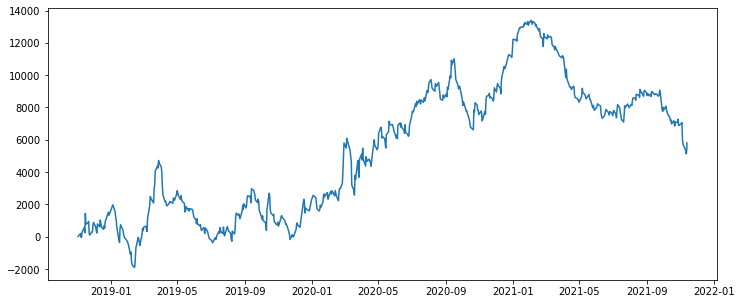

In [33]:
testing_results["total_pnl"] = testing_results.profit.cumsum()
testing_results.index = testing_results.start_position

import matplotlib.pylab as plt

plt.figure(figsize=(12,5))
plt.plot(testing_results.total_pnl)

,profit,owning_time
0,-1.768242e+02,0 days 01:00:00
1,-7.128848e+02,0 days 13:00:00
2,-1.739068e+03,0 days 10:00:00
3,-3.514752e+03,0 days 03:00:00
4,-6.524137e+03,0 days 04:00:00
...,...,...
602,-1.135690e+13,0 days 06:00:00
603,-1.142661e+13,0 days 13:00:00
604,-1.149660e+13,0 days 06:00:00
605,-1.156685e+13,0 days 11:00:00


In [5]:
d.loc[pd.Timestamp(year=2018, month=11, day=5):pd.Timestamp(year=2018, month=11, day=6)]

,open,high,low,close,line_number
time,,,,,
2018-11-05 00:00:00,NaN,NaN,NaN,NaN,97
2018-11-05 01:00:00,0.941470,0.942010,0.941400,0.942010,98
2018-11-05 02:00:00,0.942170,0.942715,0.942130,0.942660,99
2018-11-05 03:00:00,0.943090,0.943105,0.942785,0.942895,100
2018-11-05 04:00:00,0.943315,0.943320,0.943025,0.943080,101
2018-11-05 05:00:00,0.942470,0.942470,0.942085,0.942085,102
2018-11-05 06:00:00,0.941630,0.941735,0.941580,0.941700,103
2018-11-05 07:00:00,0.942030,0.942045,0.941910,0.942005,104
2018-11-05 08:00:00,0.942425,0.942445,0.942230,0.942295,105


In [6]:
d.loc[pd.Timestamp(year=2018, month=11, day=5):pd.Timestamp(year=2018, month=11, day=6)].iloc[0].isna().any()

True